Placeholder Exec Sum.


## Library Installation

In [ ]:
# Install the required libraries
#!pip install prophet
#!pip install mplfinance

## Importing Libraries

In [ ]:

import pandas as pd
import datetime as dt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import seaborn as sns
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
# Global variables
DEFAULT_SYMBOL = 'TSLA'
IPO_DATE = '2010-06-29'  # Tesla's IPO date
start_date = IPO_DATE  # Default to IPO date, can be updated based on user input

def fetch_stock_data(ticker_symbol):
    """
    Fetches stock data for the given ticker symbol from the start date to the current date.
    The start date is a global variable that can be set based on user input or defaults to Tesla's IPO date.

    Parameters:
        ticker_symbol (str): The stock ticker symbol for which data is to be fetched.

    Returns:
        DataFrame: A DataFrame containing the stock data fetched from Yahoo Finance.
    """
    return yf.download(ticker_symbol, start=start_date)

# Prompt user for start date, defaulting to Tesla's IPO date if no input is provided
user_start_date = input(f"Enter the 4 digit year to start the analysis or press enter to default to Tesla's IPO year ({IPO_DATE[:4]}): ").strip()
if user_start_date:
    start_date = f"{user_start_date}-01-01"  # Assuming the start date is the first of the input year

# Fetch Tesla stock data as the primary stock for comparison
# Fetch Tesla stock data as the primary stock for comparison
stock_1_df = fetch_stock_data(DEFAULT_SYMBOL)

# Exclude weekends from stock_1_df
stock_1_df['Date'] = pd.to_datetime(stock_1_df.index)  # Ensure 'Date' column is datetime
stock_1_df = stock_1_df[stock_1_df['Date'].dt.dayofweek < 5]  # Filter out weekends

# Prompt for the first comparison stock symbol
symbol_2 = input("Enter the first ticker symbol you would like to compare with Tesla: ").strip().upper()

# Fetch data for the first comparison stock
stock_2_df = fetch_stock_data(symbol_2)

# Exclude weekends from stock_2_df
stock_2_df['Date'] = pd.to_datetime(stock_2_df.index)  # Ensure 'Date' column is datetime
stock_2_df = stock_2_df[stock_2_df['Date'].dt.dayofweek < 5]  # Filter out weekends

# Additional logic for further analysis and comparison can be added here

def fetch_market_index(index_symbol, start_date):
    """
    Fetches market index data from Yahoo Finance.

    Parameters:
        index_symbol (str): The market index symbol (e.g., '^GSPC' for S&P 500).
        start_date (str): The start date for fetching the data.

    Returns:
        DataFrame: A DataFrame containing the market index data.
    """
    return yf.download(index_symbol, start=start_date)

# Fetch market index data (e.g., S&P 500)
market_index_df = fetch_market_index('^GSPC', start_date)
market_index_series = market_index_df['Adj Close'].rename('market_index')
stock_1_df = stock_1_df.merge(market_index_series, left_index=True, right_index=True, how='left')
stock_1_df



Enter the 4 digit year to start the analysis or press enter to default to Tesla's IPO year (2010): 


[*********************100%%**********************]  1 of 1 completed


Enter the first ticker symbol you would like to compare with Tesla: GM


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,market_index
Date,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059
...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059


In [ ]:
stock_1_df_copy = stock_1_df
stock_2_df_copy = stock_2_df

### Dataframe Creation

In [ ]:
stock_1_df


,Open,High,Low,Close,Adj Close,Volume,Date,market_index
Date,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059
...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059


In [ ]:
stock_2_df

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2010-11-18,35.000000,35.990002,33.889999,34.189999,26.027620,457044300,2010-11-18
2010-11-19,34.150002,34.500000,33.110001,34.259998,26.080914,107842000,2010-11-19
2010-11-22,34.200001,34.480000,33.810001,34.080002,25.943884,36650600,2010-11-22
2010-11-23,33.950001,33.990002,33.189999,33.250000,25.312035,31170200,2010-11-23
2010-11-24,33.730000,33.799999,33.220001,33.480000,25.487123,26138000,2010-11-24
...,...,...,...,...,...,...,...
2024-02-05,38.529999,38.689999,37.680000,37.790001,37.790001,19722400,2024-02-05
2024-02-06,37.599998,38.669998,37.599998,38.029999,38.029999,16280200,2024-02-06
2024-02-07,38.540001,39.119999,38.099998,38.720001,38.720001,19093800,2024-02-07


## Initial Plots for Validation

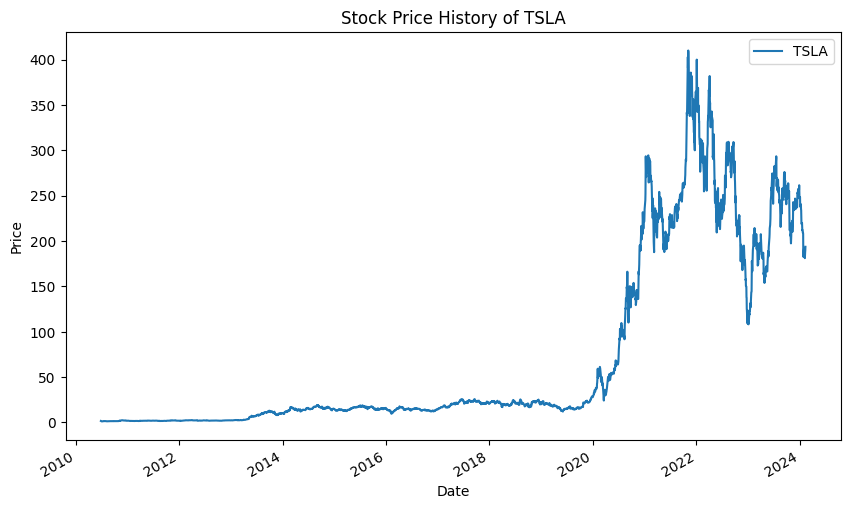

In [ ]:
# Plot the data
stock_1_df['Adj Close'].plot(title=f'Stock Price History of {DEFAULT_SYMBOL.upper()}', figsize=(10, 6))

# Add labels to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend([DEFAULT_SYMBOL.upper()])


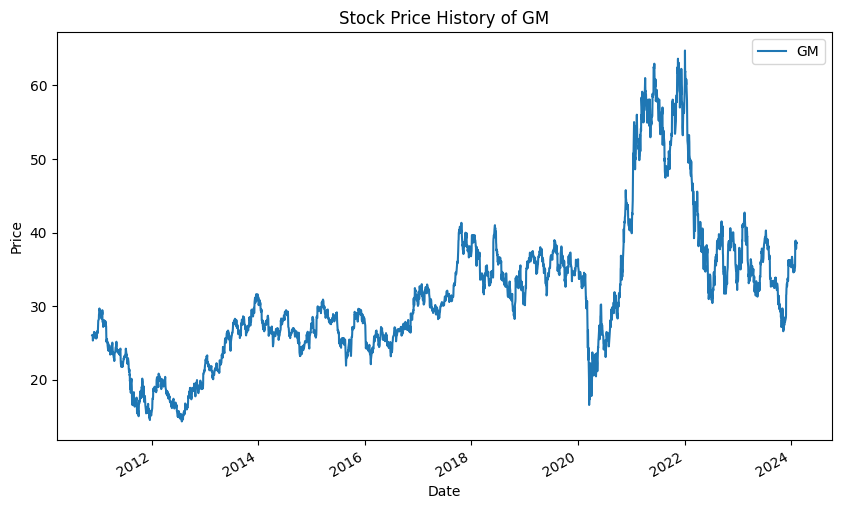

In [ ]:
# Plot the data
stock_2_df['Adj Close'].plot(title=f'Stock Price History of {symbol_2.upper()}', figsize=(10, 6))

# Add labels to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend([symbol_2.upper()])

# Display the plot
plt.show()

### Assignment of Calendar Days

In [ ]:
stock_1_df['day_of_week'] = stock_1_df.index.day_name()
stock_1_df['month'] = stock_1_df.index.month_name()
stock_1_df['year'] = stock_1_df.index.year
stock_1_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year
Date,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010


#### Average Closing Value by Day of the Week

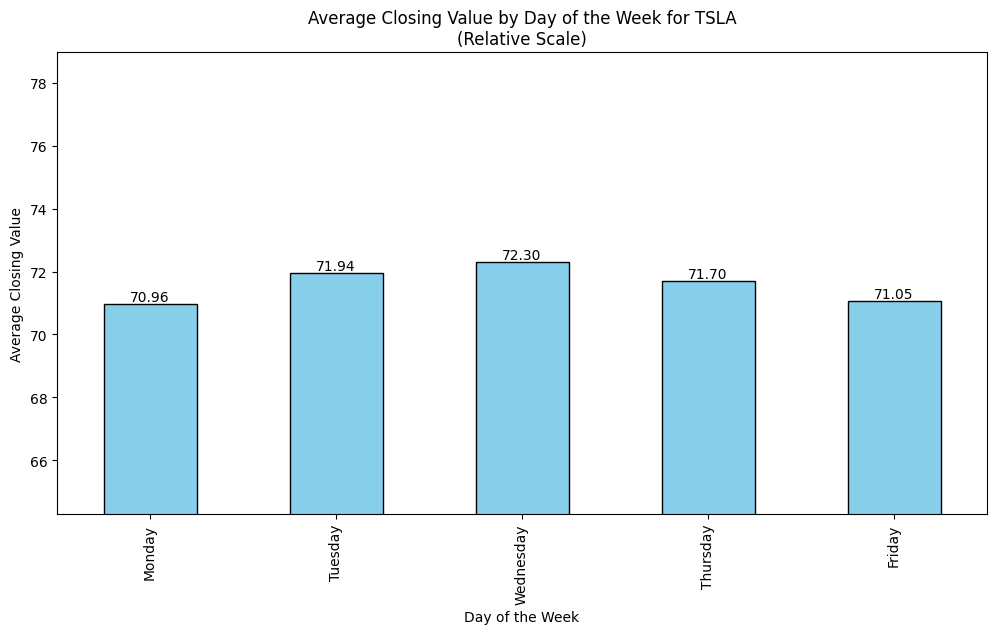

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year
Date,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024


In [ ]:
# Sort and categorize 'day_of_week' to ensure correct ordering
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
stock_1_df['day_of_week'] = pd.Categorical(stock_1_df['day_of_week'], categories=days_order, ordered=True)

# Calculate the mean close value by day of the week
avg_values = stock_1_df.groupby('day_of_week')['Close'].mean()

# Create a bar chart
plt.figure(figsize=(12, 6))
avg_values.plot(kind='bar', color='skyblue', edgecolor='black')

# Determine the range of your data and set y-axis limits with padding
data_range = avg_values.max() - avg_values.min()
padding = data_range * 5  # 10% padding on each side
plt.ylim([avg_values.min() - padding, avg_values.max() + padding])

# Add titles and labels
plt.title(f'Average Closing Value by Day of the Week for {DEFAULT_SYMBOL.upper()}\n(Relative Scale)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Closing Value')

# Add data labels on top of each bar
for index, value in enumerate(avg_values):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()
stock_1_df




#### Average Closing Value by Month

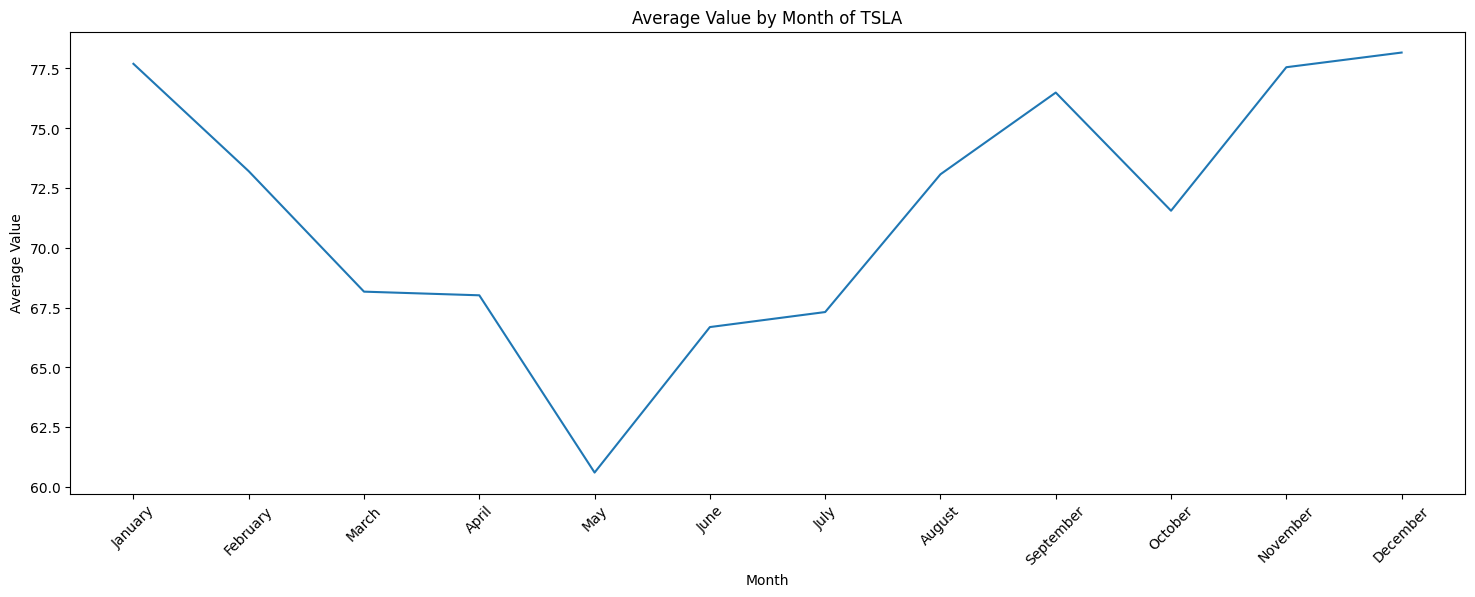

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year
Date,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024


In [ ]:
# Plotting trends by month
plt.figure(figsize=(18, 6))

# Explicitly specifying the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# First, ensure the 'month' column is categorical with the specified order
stock_1_df['month'] = pd.Categorical(stock_1_df['month'], categories=months_order, ordered=True)

# Then, group by 'month' and calculate the mean of 'Close', ensuring the result is indexed by the ordered 'month' categories
monthly_avg = stock_1_df.groupby('month')['Close'].mean().reindex(months_order)

# Plot the result
monthly_avg.plot()

# Use `set_xticks` and `set_xticklabels` to ensure all months are displayed
plt.xticks(range(len(months_order)), months_order, rotation=45)

plt.title(f'Average Value by Month of {DEFAULT_SYMBOL.upper()}')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.show()
stock_1_df


### Stock 1 Moving Averages Plot

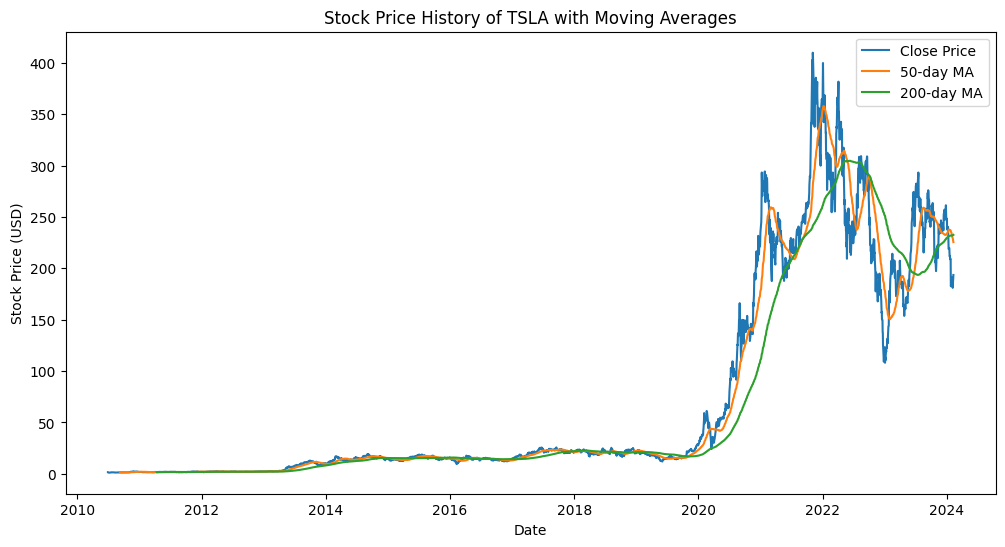

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year,MA50,MA200
Date,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010,NaN,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010,NaN,NaN
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010,NaN,NaN
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010,NaN,NaN
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024,229.5202,232.08550
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024,228.5380,232.19605
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024,227.5806,232.30855


In [ ]:
# Get general idea of price against moving averages Above 200 day = good. Below = bad Above both = great
stock_1_df['MA50'] = stock_1_df['Adj Close'].rolling(window=50).mean()
stock_1_df['MA200'] = stock_1_df['Adj Close'].rolling(window=200).mean()

# Plotting moving averages
plt.figure(figsize=(12, 6))
plt.plot(stock_1_df['Adj Close'], label='Close Price')
plt.plot(stock_1_df['MA50'], label='50-day MA')
plt.plot(stock_1_df['MA200'], label='200-day MA')
plt.title(f'Stock Price History of {DEFAULT_SYMBOL.upper()} with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()
stock_1_df




## Data-split

In [ ]:
# Assuming 'stock_1_df' is your DataFrame and you're predicting 'Adj Close'
X = stock_1_df.drop('Adj Close', axis=1)  # Features
y = stock_1_df['Adj Close']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% data as test set


In [ ]:
stock_1_df

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year,MA50,MA200
Date,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010,NaN,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010,NaN,NaN
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010,NaN,NaN
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010,NaN,NaN
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024,229.5202,232.08550
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024,228.5380,232.19605
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024,227.5806,232.30855


# Machine Learning Module

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/6haxu5bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/x457d_hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74715', 'data', 'file=/tmp/tmpaf2cxr1n/6haxu5bx.json', 'init=/tmp/tmpaf2cxr1n/x457d_hr.json', 'output', 'file=/tmp/tmpaf2cxr1n/prophet_modelj_k5to1x/prophet_model-20240211152728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Enter the number of days you want to forecast: 200


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/0artjw74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/6bfwl9a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12276', 'data', 'file=/tmp/tmpaf2cxr1n/0artjw74.json', 'init=/tmp/tmpaf2cxr1n/6bfwl9a8.json', 'output', 'file=/tmp/tmpaf2cxr1n/prophet_model2gx6jy5q/prophet_model-20240211152739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


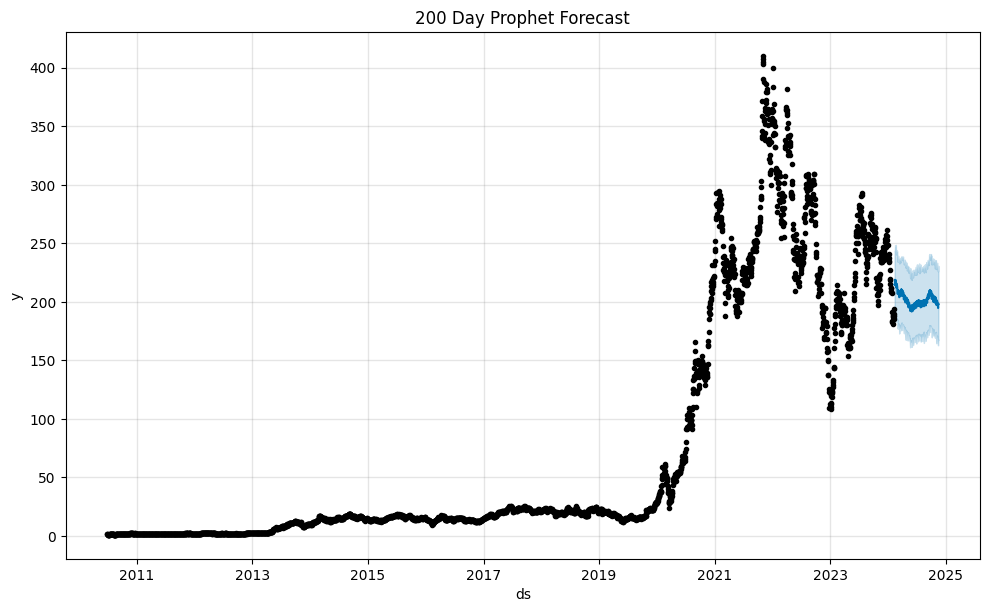

In [ ]:


# Initialize the Prophet model for the main forecast
prophet_model = Prophet()
prophet_model.add_regressor('market_index')
prophet_model.add_country_holidays(country_name='US')

scaling_factor = 1  # Example scaling factor, adjust based on your needs
stock_1_df['market_index_scaled'] = stock_1_df['market_index'] * scaling_factor

# Fill NaN values with the mean of the columns, excluding non-numeric columns
numeric_cols = stock_1_df.select_dtypes(include=['number']).columns
stock_1_df[numeric_cols] = stock_1_df[numeric_cols].fillna(stock_1_df[numeric_cols].mean())

# Preparing data for Prophet
# Check if 'Date' is already a column and handle accordingly
if 'Date' not in stock_1_df.columns:
    stock_1_df.reset_index(inplace=True)
# If 'Date' is in columns, ensure it's in datetime format
else:
    stock_1_df['Date'] = pd.to_datetime(stock_1_df['Date'])

# Filter out weekends from the DataFrame
stock_1_df = stock_1_df[stock_1_df['Date'].dt.weekday < 5]

# Rename columns for Prophet compatibility
stock_1_df.rename(columns={'Date': 'ds', 'Adj Close': 'y', 'market_index': 'market_index'}, inplace=True)

# Fit the main Prophet model
prophet_model.fit(stock_1_df)

# User input for forecast period
forecast_days = int(input("Enter the number of days you want to forecast: "))

# Prepare the market_index data for its own forecast
market_index_df = stock_1_df[['ds', 'market_index']].rename(columns={'market_index': 'y'})

# Initialize and fit the Prophet model for market_index
market_prophet = Prophet()
market_prophet.fit(market_index_df)

# Create a future DataFrame for the market_index forecast
market_future = market_prophet.make_future_dataframe(periods=forecast_days)

# Forecast future values of market_index
market_forecast = market_prophet.predict(market_future)

# Use the trained model to make predictions on the historical data
historical_forecast = prophet_model.predict(stock_1_df)

# Extract the forecasted market_index values for the future period only
future_market_index = market_forecast['yhat'].iloc[-forecast_days:].values

# Create a custom future DataFrame that excludes weekends
last_date = stock_1_df['ds'].max()
future = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='B').to_frame(index=False, name='ds')

# The number of historical dates in the future DataFrame
num_historical_dates = len(future) - forecast_days

# Ensure existing_market_index covers the historical period in the future DataFrame
existing_market_index = stock_1_df['market_index'].iloc[:num_historical_dates]

# Combine the historical market_index values with the forecasted ones
combined_market_index = np.concatenate((existing_market_index, future_market_index))

# Check if the lengths match
assert len(combined_market_index) == len(future), f"Lengths do not match: {len(combined_market_index)} vs {len(future)}."

# Add the combined market_index values to the 'future' DataFrame
future['market_index'] = combined_market_index

# Make the final forecast with the external regressor
forecast = prophet_model.predict(future)

# Plotting
fig = prophet_model.plot(forecast)
plt.title(f'{forecast_days} Day Prophet Forecast')
plt.show()


In [ ]:
historical_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-06-29,100.727579,-40.354973,20.077235,100.727579,100.727579,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-1.327081,-1.327081,-1.327081,0.0,0.0,0.0,-8.578865
1,2010-06-30,100.702603,-39.768846,18.633501,100.702603,100.702603,0.0,0.0,0.0,0.0,...,20.105456,20.105456,20.105456,-1.194283,-1.194283,-1.194283,0.0,0.0,0.0,-9.138843
2,2010-07-01,100.677626,-37.964861,18.861504,100.677626,100.677626,0.0,0.0,0.0,0.0,...,19.751945,19.751945,19.751945,-1.070314,-1.070314,-1.070314,0.0,0.0,0.0,-9.666703
3,2010-07-02,100.652649,-39.111134,16.696742,100.652649,100.652649,0.0,0.0,0.0,0.0,...,19.463002,19.463002,19.463002,-0.956484,-0.956484,-0.956484,0.0,0.0,0.0,-10.258801
4,2010-07-06,100.552742,-36.471304,19.703445,100.552742,100.552742,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-0.630286,-0.630286,-0.630286,0.0,0.0,0.0,-9.135545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,2024-02-05,54.552146,236.013036,294.037498,54.552146,54.552146,0.0,0.0,0.0,0.0,...,20.374030,20.374030,20.374030,-1.651270,-1.651270,-1.651270,0.0,0.0,0.0,264.686208
3424,2024-02-06,54.484848,236.550772,295.337439,54.484848,54.484848,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-1.279600,-1.279600,-1.279600,0.0,0.0,0.0,265.462635
3425,2024-02-07,54.417550,239.943758,297.502616,54.417550,54.417550,0.0,0.0,0.0,0.0,...,20.105456,20.105456,20.105456,-0.891163,-0.891163,-0.891163,0.0,0.0,0.0,269.319254
3426,2024-02-08,54.350252,238.961260,296.522419,54.350252,54.350252,0.0,0.0,0.0,0.0,...,19.751945,19.751945,19.751945,-0.495173,-0.495173,-0.495173,0.0,0.0,0.0,269.527685


In [ ]:
# Assuming `X` initially contains all the columns including datetime and categorical columns
# Exclude datetime columns from X
X = X.select_dtypes(exclude=['datetime64'])

# One-hot encode categorical columns if needed (ensure 'day_of_week' and 'month' are not datetime columns)
X = pd.get_dummies(X, columns=['day_of_week', 'month'])  # Adjust the columns list as per your DataFrame

# Initialize the SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or use 'median' if more appropriate

# Apply the imputer to numeric columns in X
X_imputed = imputer.fit_transform(X)

# If X had column names and you wish to convert X_imputed back to a DataFrame:
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)


## Cross-Validation

In [ ]:
df_cv = cross_validation(prophet_model, initial='720 days', period='140 days', horizon='365 days')

df_cv

df_p = performance_metrics(df_cv)

INFO:prophet:Making 28 forecasts with cutoffs between 2012-10-04 00:00:00 and 2023-02-09 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/p298n4q8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/u0wyslf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20287', 'data', 'file=/tmp/tmpaf2cxr1n/p298n4q8.json', 'init=/tmp/tmpaf2cxr1n/u0wyslf6.json', 'output', 'file=/tmp/tmpaf2cxr1n/prophet_modelarwg44nl/prophet_model-20240211152806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/w5xxl28m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaf2cxr1n/0hkn4hdc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

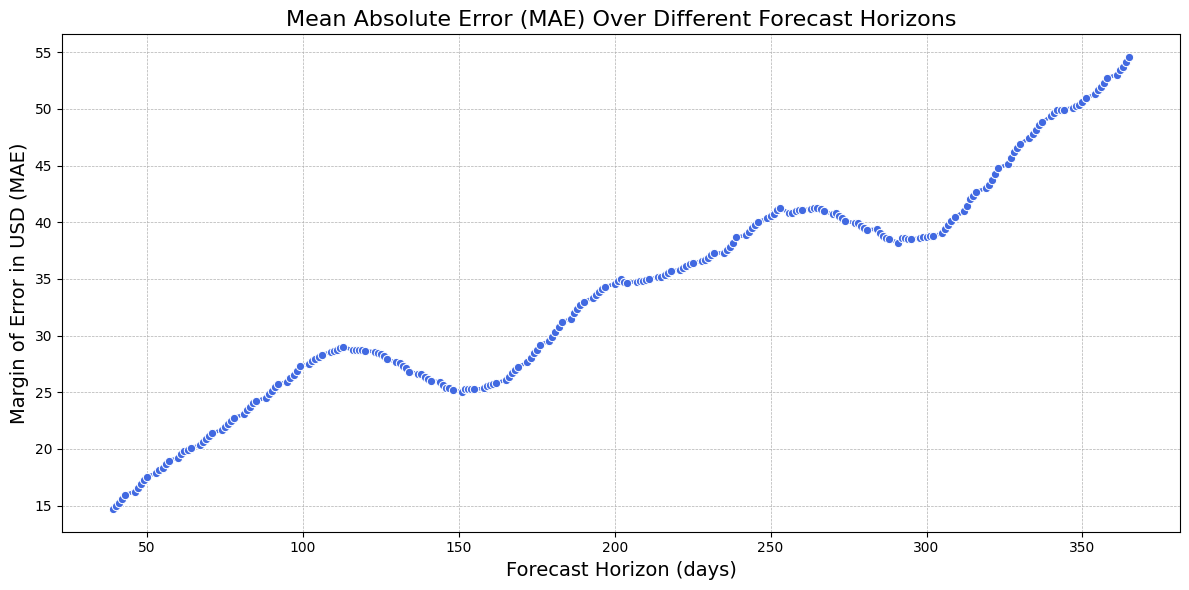

     horizon        mae  horizon_days
0    39 days  14.683930            39
1    40 days  14.955444            40
2    41 days  15.251794            41
3    42 days  15.583448            42
4    43 days  15.948096            43
..       ...        ...           ...
230 361 days  53.024414           361
231 362 days  53.398333           362
232 363 days  53.748780           363
233 364 days  54.190108           364
234 365 days  54.593024           365

[235 rows x 3 columns]


In [ ]:
# Assuming df_p is the performance metrics DataFrame obtained from Prophet's performance_metrics function
mae_data = df_p[['horizon', 'mae']].copy()

plt.figure(figsize=(12, 6))

# Convert 'horizon' from days to a more readable format if necessary (e.g., number of days)
mae_data['horizon_days'] = mae_data['horizon'].dt.days

# Create the plot
sns.lineplot(x='horizon_days', y='mae', data=mae_data, marker='o', color='royalblue', linewidth=2.5)

# Enhance the plot
plt.title('Mean Absolute Error (MAE) Over Different Forecast Horizons', fontsize=16)
plt.xlabel('Forecast Horizon (days)', fontsize=14)
plt.ylabel('Margin of Error in USD (MAE)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
print(mae_data)

In [ ]:
# Rename 'ds' column to 'Date' and 'y' column to 'Adj Close'
stock_1_df.rename(columns={'ds': 'Date', 'y': 'Adj Close'}, inplace=True)
stock_1_df

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year,MA50,MA200,market_index_scaled
Date,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010,71.089507,68.764426,1041.239990
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010,71.089507,68.764426,1030.709961
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010,71.089507,68.764426,1027.369995
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010,71.089507,68.764426,1022.580017
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010,71.089507,68.764426,1028.060059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024,229.520200,232.085500,4942.810059
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024,228.538000,232.196050,4954.229980
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024,227.580600,232.308550,4995.060059


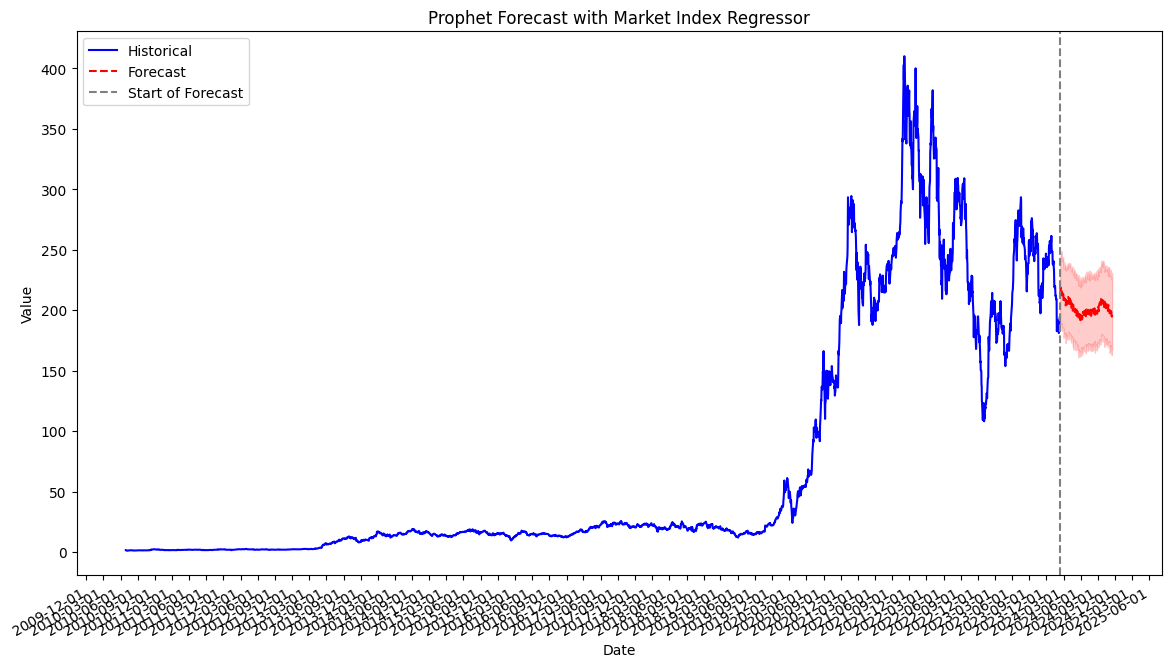

In [ ]:
# Plot historical data
plt.figure(figsize=(14, 8))
plt.plot(stock_1_df['Date'], stock_1_df['Adj Close'], label='Historical', color='blue')

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')

# Highlight forecast period
plt.axvline(x=stock_1_df['Date'].iloc[-1], color='gray', linestyle='--', label='Start of Forecast')

# Optionally, plot components of the forecast, such as confidence intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)

# Formatting
plt.title('Prophet Forecast with Market Index Regressor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotation

plt.show()

In [ ]:
stock_1_df

,Open,High,Low,Close,Adj Close,Volume,Date,market_index,day_of_week,month,year,MA50,MA200,market_index_scaled
Date,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010-06-29,1041.239990,Tuesday,June,2010,71.089507,68.764426,1041.239990
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010-06-30,1030.709961,Wednesday,June,2010,71.089507,68.764426,1030.709961
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010-07-01,1027.369995,Thursday,July,2010,71.089507,68.764426,1027.369995
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010-07-02,1022.580017,Friday,July,2010,71.089507,68.764426,1022.580017
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010-07-06,1028.060059,Tuesday,July,2010,71.089507,68.764426,1028.060059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024,229.520200,232.085500,4942.810059
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024,228.538000,232.196050,4954.229980
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024,227.580600,232.308550,4995.060059


In [ ]:
historical_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-06-29,100.727579,-40.354973,20.077235,100.727579,100.727579,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-1.327081,-1.327081,-1.327081,0.0,0.0,0.0,-8.578865
1,2010-06-30,100.702603,-39.768846,18.633501,100.702603,100.702603,0.0,0.0,0.0,0.0,...,20.105456,20.105456,20.105456,-1.194283,-1.194283,-1.194283,0.0,0.0,0.0,-9.138843
2,2010-07-01,100.677626,-37.964861,18.861504,100.677626,100.677626,0.0,0.0,0.0,0.0,...,19.751945,19.751945,19.751945,-1.070314,-1.070314,-1.070314,0.0,0.0,0.0,-9.666703
3,2010-07-02,100.652649,-39.111134,16.696742,100.652649,100.652649,0.0,0.0,0.0,0.0,...,19.463002,19.463002,19.463002,-0.956484,-0.956484,-0.956484,0.0,0.0,0.0,-10.258801
4,2010-07-06,100.552742,-36.471304,19.703445,100.552742,100.552742,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-0.630286,-0.630286,-0.630286,0.0,0.0,0.0,-9.135545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,2024-02-05,54.552146,236.013036,294.037498,54.552146,54.552146,0.0,0.0,0.0,0.0,...,20.374030,20.374030,20.374030,-1.651270,-1.651270,-1.651270,0.0,0.0,0.0,264.686208
3424,2024-02-06,54.484848,236.550772,295.337439,54.484848,54.484848,0.0,0.0,0.0,0.0,...,19.911484,19.911484,19.911484,-1.279600,-1.279600,-1.279600,0.0,0.0,0.0,265.462635
3425,2024-02-07,54.417550,239.943758,297.502616,54.417550,54.417550,0.0,0.0,0.0,0.0,...,20.105456,20.105456,20.105456,-0.891163,-0.891163,-0.891163,0.0,0.0,0.0,269.319254
3426,2024-02-08,54.350252,238.961260,296.522419,54.350252,54.350252,0.0,0.0,0.0,0.0,...,19.751945,19.751945,19.751945,-0.495173,-0.495173,-0.495173,0.0,0.0,0.0,269.527685


## Machine Learning Report

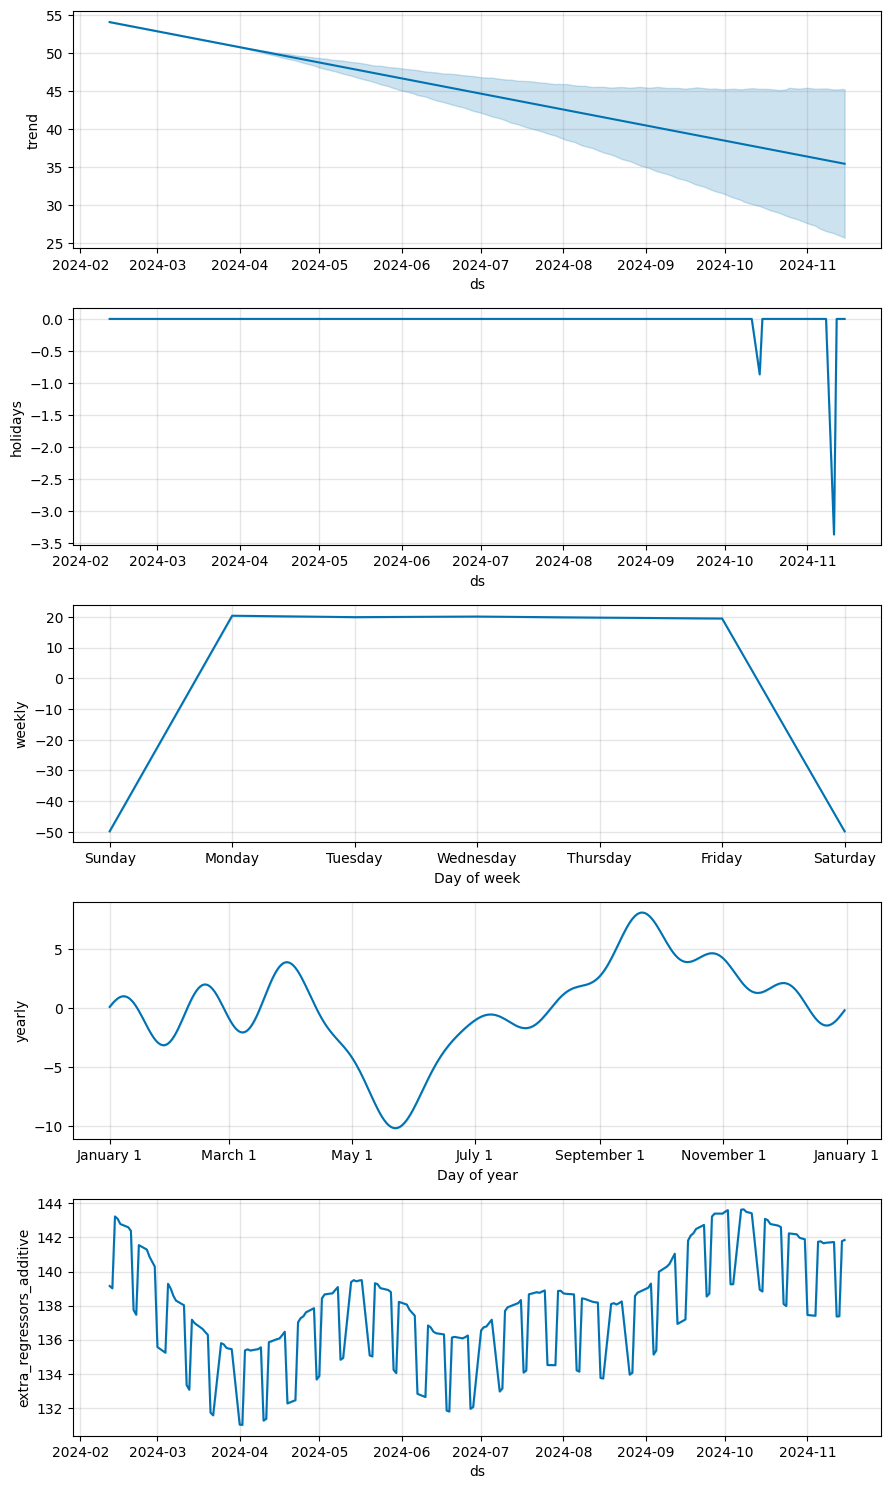

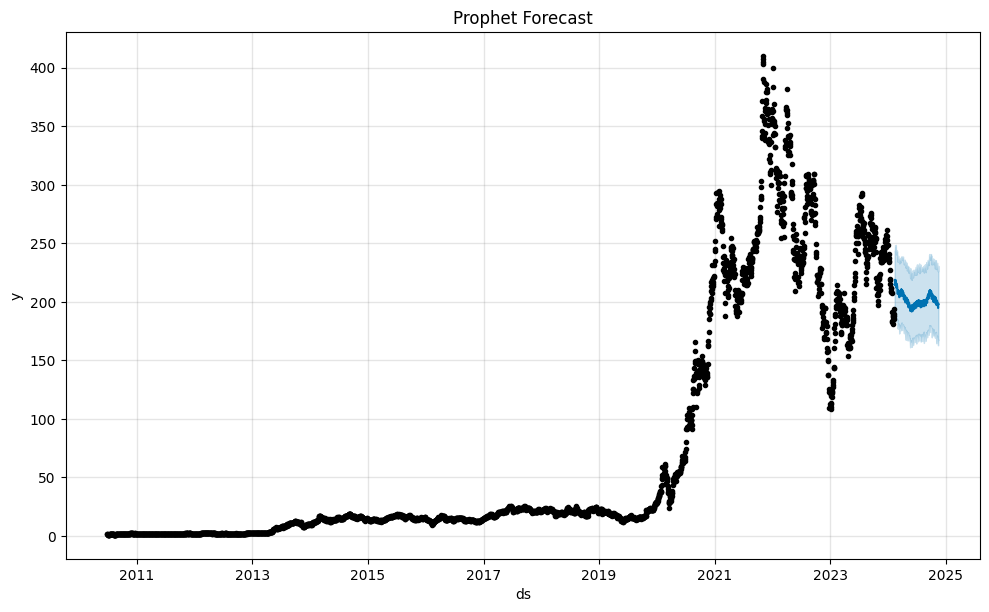

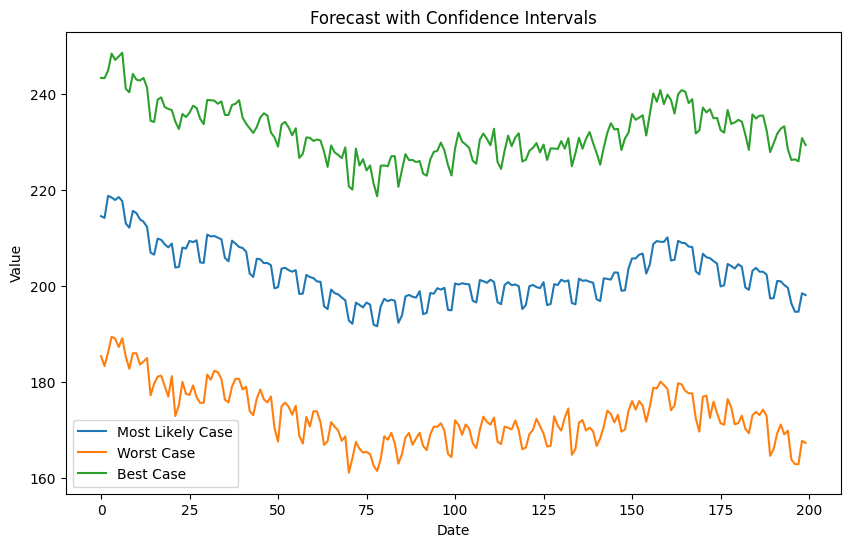

Forecasted Prices for March 2024:
           ds        yhat
14 2024-03-01  206.962572
15 2024-03-04  206.559407
16 2024-03-05  209.907566
17 2024-03-06  209.631855
18 2024-03-07  208.721464
19 2024-03-08  208.078120
20 2024-03-11  208.864730
21 2024-03-12  203.878292
22 2024-03-13  204.005129
23 2024-03-14  208.027172
24 2024-03-15  207.830292
25 2024-03-18  209.437759
26 2024-03-19  209.154511
27 2024-03-20  209.542807
28 2024-03-21  204.960392
29 2024-03-22  204.831962
30 2024-03-25  210.733600
31 2024-03-26  210.354877
32 2024-03-27  210.449402
33 2024-03-28  210.095550
34 2024-03-29  209.771142


In [ ]:
# Plotting the Prophet forecast

forecast_weekdays = forecast[forecast['ds'].dt.dayofweek < 5]
# Plotting the components
fig = prophet_model.plot_components(forecast)
plt.show()

fig = prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Create a copy of the forecast DataFrame with the columns renamed
forecast_renamed = forecast[["yhat", "yhat_lower", "yhat_upper"]].rename(
    columns={
        "yhat": "Most Likely Case",
        "yhat_lower": "Worst Case",
        "yhat_upper": "Best Case"
    }
)

# Selecting the forecast period for plotting
forecast_subset = forecast_renamed.iloc[-forecast_days:, :]

# Plotting
forecast_subset.plot(figsize=(10, 6))
plt.title('Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Filter the forecast DataFrame for March 2024
march_2024_forecast = forecast[(forecast['ds'] >= '2024-03-01') & (forecast['ds'] <= '2024-03-31')]

# Display the forecasted prices for March 2024
print("Forecasted Prices for March 2024:")
print(march_2024_forecast[['ds', 'yhat']])

# After Prophet modeling is done and you need to rename 'y' back to 'Adj Close'
stock_1_df.rename(columns={'y': 'Adj Close', 'ds': 'Date'}, inplace=True)


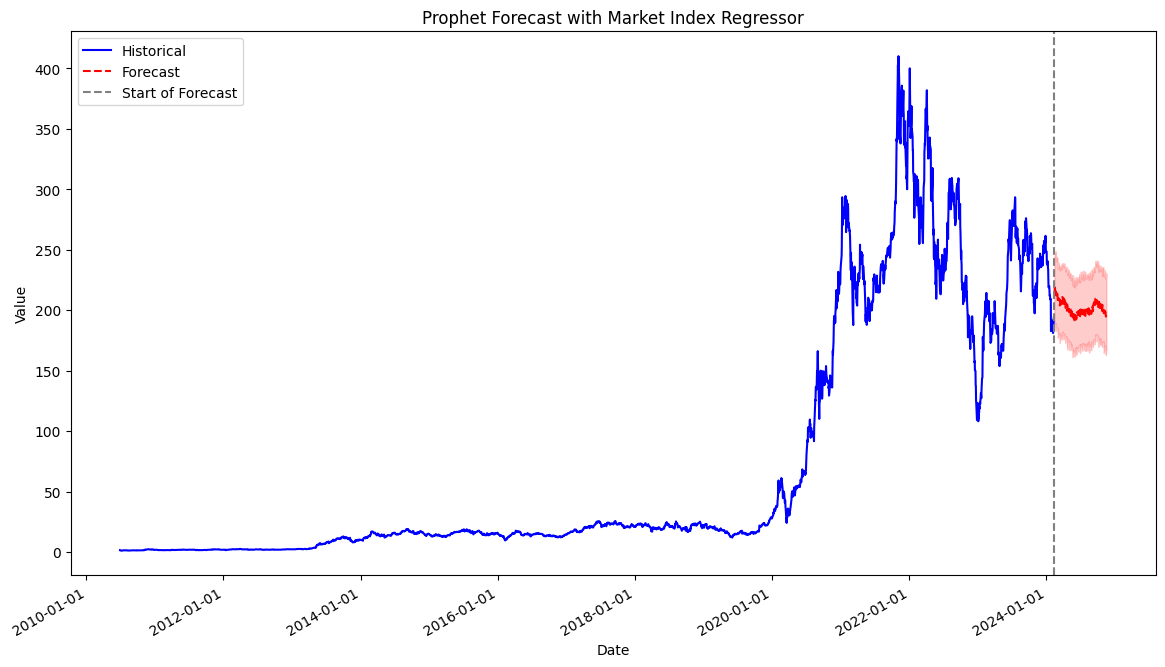

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df_prophet = stock_1_df.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

# Use the trained model to make predictions on the historical data
historical_forecast = prophet_model.predict(df_prophet)

# Ensure 'Date' is in the proper format if it's not already
stock_1_df['Date'] = pd.to_datetime(stock_1_df['Date'])

# Plot historical data
plt.figure(figsize=(14, 8))
plt.plot(stock_1_df['Date'], stock_1_df['Adj Close'], label='Historical', color='blue')

# Plot forecast (both historical fit and future predictions)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')

# Highlight the start of the future forecast period
last_hist_date = stock_1_df['Date'].iloc[-1]
plt.axvline(x=last_hist_date, color='gray', linestyle='--', label='Start of Forecast')

# Optionally, plot confidence intervals for the forecast
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)

# Formatting
plt.title('Prophet Forecast with Market Index Regressor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Set date formatting for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation and alignment of x-axis labels

plt.show()


### Stock 1 Volatility

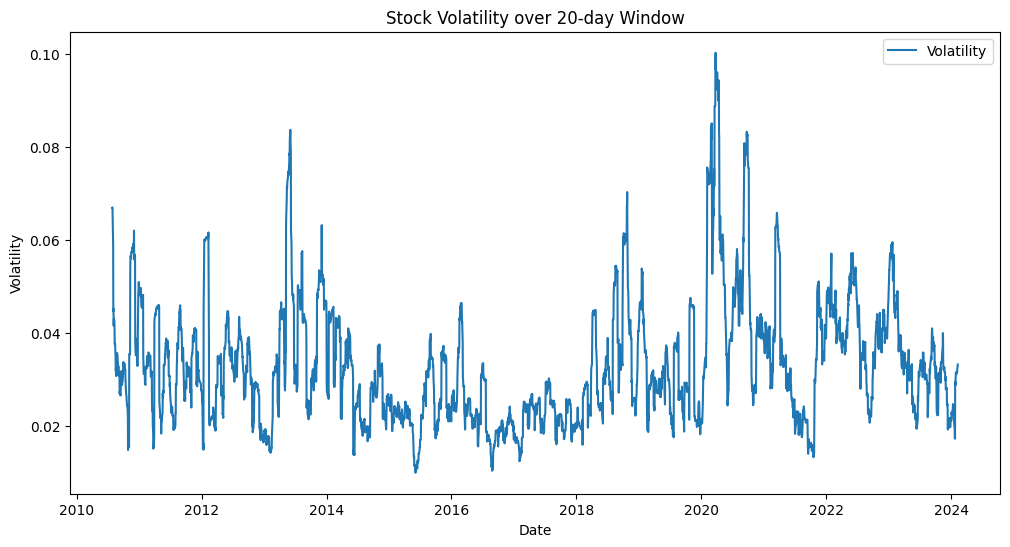

In [ ]:
def plot_stock_volatility(stock_data, window=20):
    # Parameters:
    # - stock_data (DataFrame): DataFrame containing stock price data, with columns including 'ds' for dates and 'y' for closing prices.
    # - window (int): The moving window size for calculating volatility.

    # Returns:
    # - A matplotlib plot showing the stock's volatility over time.

    # Calculate daily returns as percentage change in closing price
    stock_1_df['daily_returns'] = stock_1_df['Adj Close'].pct_change()

    # Calculate rolling standard deviation of daily returns over the specified window to represent volatility
    stock_1_df['volatility'] = stock_1_df['daily_returns'].rolling(window=window).std()

    # Plotting the volatility
    plt.figure(figsize=(12, 6))
    plt.plot(stock_1_df['Date'], stock_1_df['volatility'], label='Volatility')
    plt.title(f'Stock Volatility over {window}-day Window')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Assuming `stock_1_df` is your DataFrame with 'ds' as date column and 'y' as closing price
plot_stock_volatility(stock_1_df)


In [ ]:
# Calculate daily percentage change. `pct_change()` computes the percentage change from the previous row by default.
stock_1_df['Daily Change (%)'] = stock_1_df['Close'].pct_change() * 100

# Sort the DataFrame based on the 'Daily Change (%)' in descending order to get the days with the largest moves first
largest_moves = stock_1_df.sort_values(by='Daily Change (%)', ascending=False)

# Display the top 5 days with the largest moves
print(largest_moves[['Date', 'Daily Change (%)']].head(5))

                 Date  Daily Change (%)
Date                                   
2013-05-09 2013-05-09         24.395076
2020-02-03 2020-02-03         19.894859
2021-03-09 2021-03-09         19.641208
2010-11-10 2010-11-10         19.204203
2020-03-19 2020-03-19         18.387684


<ipython-input-28-8ec48b62f44a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Date', y='Daily Change (%)', data=top_5_moves, palette='viridis', edgecolor='black')


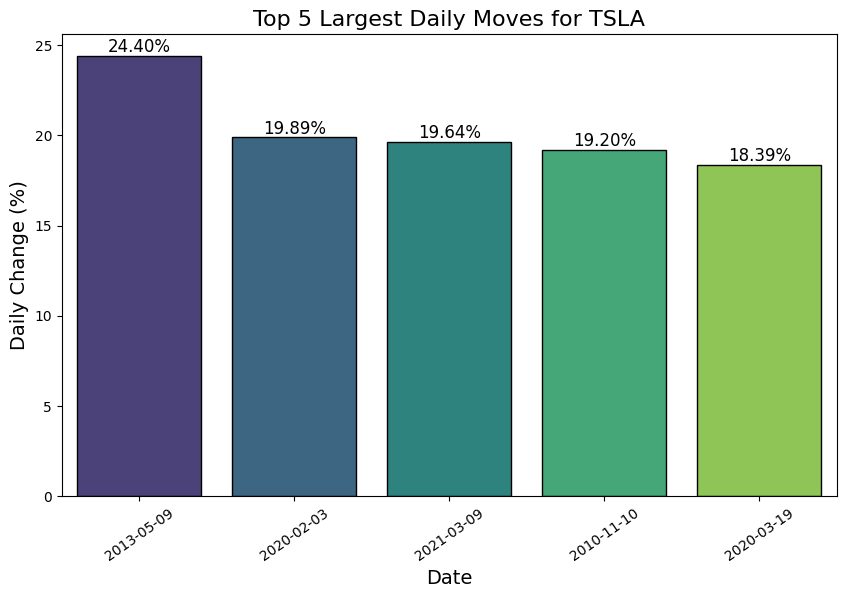

In [ ]:
top_5_moves = largest_moves.head(5)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
ax = sns.barplot(x='Date', y='Daily Change (%)', data=top_5_moves, palette='viridis', edgecolor='black')

# Add titles and labels
plt.title(f'Top 5 Largest Daily Moves for {DEFAULT_SYMBOL.upper()}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Change (%)', fontsize=14)
plt.xticks(rotation=35)  # Rotate the x-axis labels for better readability

# Overlay the values on the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2.,  # x position
            p.get_height(),  # y position
            '{:.2f}%'.format(p.get_height()),  # text
            fontsize=12,
            ha='center',  # horizontal alignment
            va='bottom')  # vertical alignment

# Display
plt.show()


### Stock 1 MACD

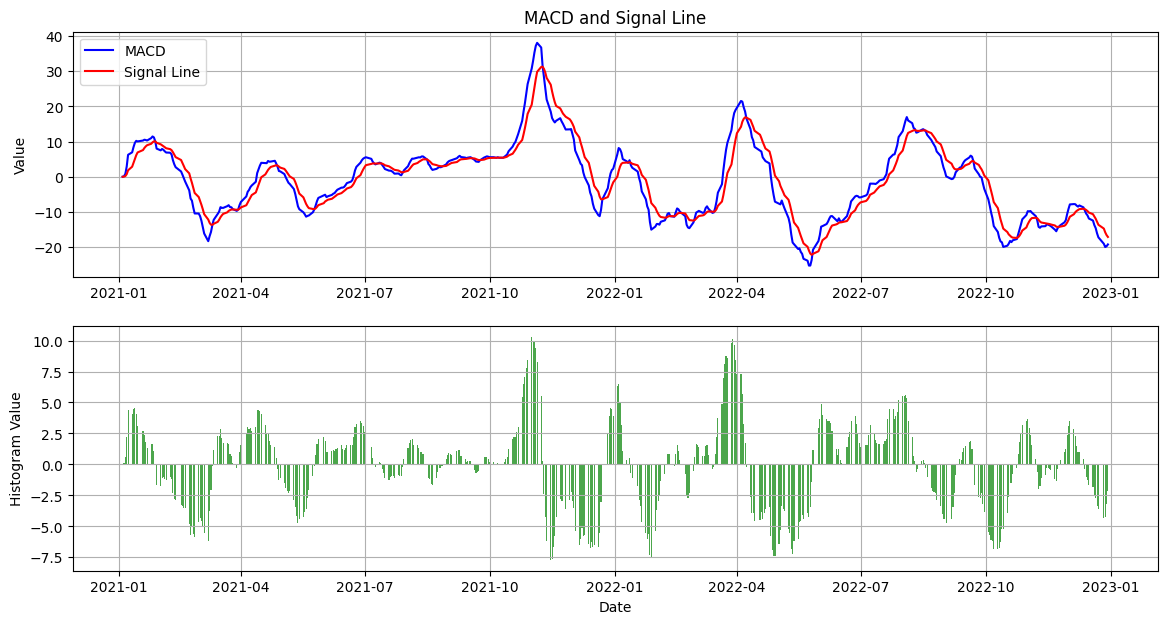

In [ ]:

def plot_macd(stock_data, start_date=None, end_date=None, date_column='Date', close_column='Adj Close'):
    """
    Calculates and plots the MACD line, Signal line, and MACD Histogram for stock data within a specified date range.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock price data, with columns for dates and closing prices.
    - start_date (str): The start date for the analysis in 'YYYY-MM-DD' format. If None, analysis starts from the first available date.
    - end_date (str): The end date for the analysis in 'YYYY-MM-DD' format. If None, analysis ends at the last available date.
    - date_column (str): The name of the column in `stock_data` that contains date information.
    - close_column (str): The name of the column in `stock_data` that contains closing price information.

    Returns:
    - A matplotlib plot showing the MACD line, Signal line, and MACD Histogram within the specified date range.
    """
    # Filter the data for the specified date range
    if start_date:
        stock_data = stock_data[stock_data[date_column] >= start_date]
    if end_date:
        stock_data = stock_data[stock_data[date_column] <= end_date]

    # Ensure the DataFrame is sorted by date
    #stock_data = stock_data.sort_values(by=date_column)

    # Calculate the MACD and Signal Line indicators
    short_ema = stock_data[close_column].ewm(span=12, adjust=False).mean()
    long_ema = stock_data[close_column].ewm(span=26, adjust=False).mean()
    stock_data['MACD'] = short_ema - long_ema
    stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
    stock_data['MACD_Histogram'] = stock_data['MACD'] - stock_data['Signal_Line']

    # Plotting
    plt.figure(figsize=(14, 7))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(stock_data[date_column], stock_data['MACD'], label='MACD', color='blue', linewidth=1.5)
    ax1.plot(stock_data[date_column], stock_data['Signal_Line'], label='Signal Line', color='red', linewidth=1.5)
    ax1.legend(loc='upper left')
    ax1.set_title('MACD and Signal Line')
    ax1.set_ylabel('Value')
    ax1.grid(True)

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.bar(stock_data[date_column], stock_data['MACD_Histogram'], label='Histogram', color='green', alpha=0.7)
    ax2.grid(True)
    ax2.set_ylabel('Histogram Value')
    ax2.set_xlabel('Date')

    plt.show()

# Usage example with 'stock_1_df' DataFrame and specifying a date range
plot_macd(stock_1_df, start_date='2021-01-01', end_date='2022-12-31')


### Stock 1 Bollinger Bands

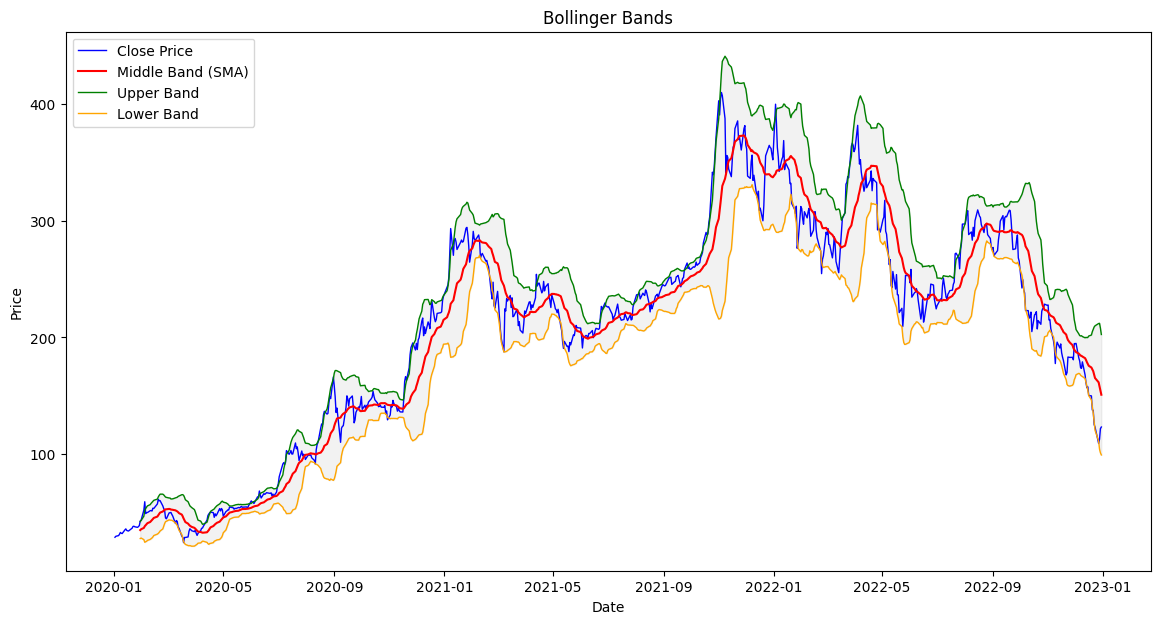

In [ ]:
def plot_bollinger_bands(stock_data, start_date=None, end_date=None, window=20, width=2, date_column='Date', close_column='Adj Close'):
    """
    Calculates and plots Bollinger Bands for stock data within a specified date range.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock price data, with columns for dates and closing prices.
    - start_date (str): The start date for the analysis in 'YYYY-MM-DD' format. If None, analysis starts from the first available date.
    - end_date (str): The end date for the analysis in 'YYYY-MM-DD' format. If None, analysis ends at the last available date.
    - window (int): The moving window size for calculating the simple moving average (SMA) and standard deviation. Default is 20.
    - width (int): The number of standard deviations away from the SMA the upper and lower bands should be. Default is 2.
    - date_column (str): The name of the column in `stock_data` that contains date information.
    - close_column (str): The name of the column in `stock_data` that contains closing price information.

    Returns:
    - A matplotlib plot showing the Bollinger Bands and the closing price within the specified date range.
    """
    # Filter the data for the specified date range
    if start_date:
        stock_data = stock_data[stock_data[date_column] >= start_date]
    if end_date:
        stock_data = stock_data[stock_data[date_column] <= end_date]

    # Ensure the DataFrame is sorted by date
    # hd
    # stock_data = stock_data.sort_values(by=index)

    # Calculate the middle band (simple moving average)
    stock_data['Middle_Band'] = stock_data[close_column].rolling(window=window).mean()

    # Calculate the standard deviation
    std_dev = stock_data[close_column].rolling(window=window).std()

    # Calculate the upper and lower bands
    stock_data['Upper_Band'] = stock_data['Middle_Band'] + (std_dev * width)
    stock_data['Lower_Band'] = stock_data['Middle_Band'] - (std_dev * width)

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data[date_column], stock_data[close_column], label='Close Price', color='blue', linewidth=1)
    plt.plot(stock_data[date_column], stock_data['Middle_Band'], label='Middle Band (SMA)', color='red', linewidth=1.5)
    plt.plot(stock_data[date_column], stock_data['Upper_Band'], label='Upper Band', color='green', linewidth=1)
    plt.plot(stock_data[date_column], stock_data['Lower_Band'], label='Lower Band', color='orange', linewidth=1)

    plt.fill_between(stock_data[date_column], stock_data['Lower_Band'], stock_data['Upper_Band'], color='grey', alpha=0.1)

    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()

# Usage example with 'stock_1_df' DataFrame and specifying a date range
plot_bollinger_bands(stock_1_df, start_date='2020-01-01', end_date='2022-12-31')


## Stock 1 and 2 DataFrame Merging

In [ ]:
# Reset the index and drop it if 'Date' is part of the index
if 'Date' in stock_1_df_copy.index.names:
    stock_1_df_copy = stock_1_df_copy.reset_index(drop=True)

if 'Date' in stock_2_df_copy.index.names:
    stock_2_df_copy = stock_2_df_copy.reset_index(drop=True)

merged_df = pd.merge(stock_1_df_copy, stock_2_df_copy, on='Date', suffixes=(f'_{DEFAULT_SYMBOL}', f'_{symbol_2}'))


In [ ]:
merged_df

,Open_TSLA,High_TSLA,Low_TSLA,Close_TSLA,Adj Close_TSLA,Volume_TSLA,Date,market_index,day_of_week,month,year,MA50,MA200,market_index_scaled,Open_GM,High_GM,Low_GM,Close_GM,Adj Close_GM,Volume_GM
0,2.044667,2.049333,1.928000,1.992667,1.992667,14341500,2010-11-18,1196.689941,Thursday,November,2010,1.488387,68.764426,1196.689941,35.000000,35.990002,33.889999,34.189999,26.027620,457044300
1,2.010667,2.091333,1.980000,2.066000,2.066000,17257500,2010-11-19,1199.729980,Friday,November,2010,1.502813,68.764426,1199.729980,34.150002,34.500000,33.110001,34.259998,26.080914,107842000
2,2.104667,2.230000,2.100000,2.226667,2.226667,22945500,2010-11-22,1197.839966,Monday,November,2010,1.519720,68.764426,1197.839966,34.200001,34.480000,33.810001,34.080002,25.943884,36650600
3,2.219333,2.378667,2.146000,2.304667,2.304667,23667000,2010-11-23,1180.729980,Tuesday,November,2010,1.537653,68.764426,1180.729980,33.950001,33.990002,33.189999,33.250000,25.312035,31170200
4,2.351333,2.398000,2.288667,2.364667,2.364667,21375000,2010-11-24,1198.349976,Wednesday,November,2010,1.555640,68.764426,1198.349976,33.730000,33.799999,33.220001,33.480000,25.487123,26138000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,184.259995,184.679993,175.009995,181.059998,181.059998,134294400,2024-02-05,4942.810059,Monday,February,2024,229.520200,232.085500,4942.810059,38.529999,38.689999,37.680000,37.790001,37.790001,19722400
3324,177.210007,186.490005,177.110001,185.100006,185.100006,122676000,2024-02-06,4954.229980,Tuesday,February,2024,228.538000,232.196050,4954.229980,37.599998,38.669998,37.599998,38.029999,38.029999,16280200
3325,188.179993,189.789993,182.679993,187.580002,187.580002,111535200,2024-02-07,4995.060059,Wednesday,February,2024,227.580600,232.308550,4995.060059,38.540001,39.119999,38.099998,38.720001,38.720001,19093800
3326,189.000000,191.619995,185.580002,189.559998,189.559998,83034000,2024-02-08,4997.910156,Thursday,February,2024,226.650200,232.443600,4997.910156,38.840000,38.939999,38.419998,38.650002,38.650002,15864500


### Merged DF Comparisons

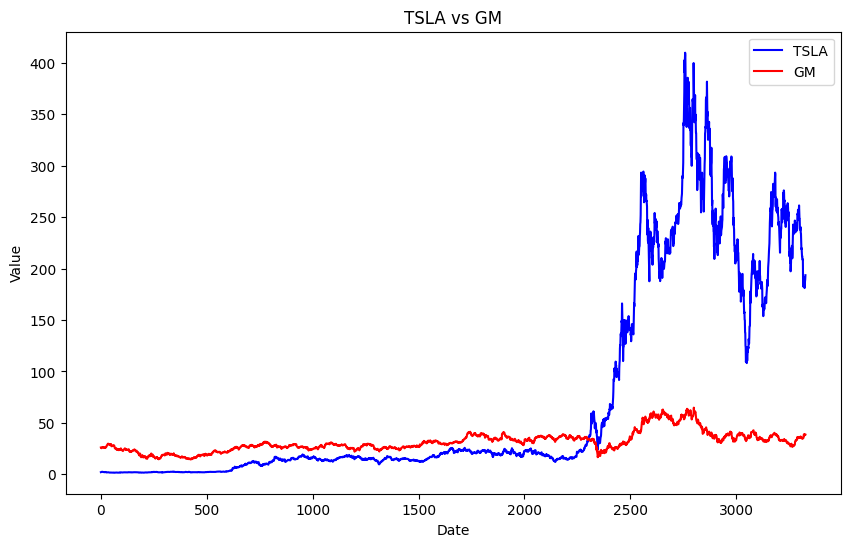

'\nYou NEEEED to add dates to the X\n'

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot

# Plotting Feature1
plt.plot(merged_df.index, merged_df[f'Adj Close_{DEFAULT_SYMBOL}'], label=f'{DEFAULT_SYMBOL.upper()}', color='blue')

# Plotting Feature2
plt.plot(merged_df.index, merged_df[f'Adj Close_{symbol_2}'], label=f'{symbol_2.upper()}', color='red')

# Adding titles and labels
plt.title(f'{DEFAULT_SYMBOL.upper()} vs {symbol_2.upper()}')
plt.xlabel('Date')
plt.ylabel('Value')

# Adding a legend
plt.legend()

# Display the plot
plt.show()




"""
You NEEEED to add dates to the X
"""

In [ ]:
print(merged_df.columns)


Index(['Open_TSLA', 'High_TSLA', 'Low_TSLA', 'Close_TSLA', 'Adj Close_TSLA',
       'Volume_TSLA', 'Date', 'market_index', 'day_of_week', 'month', 'year',
       'MA50', 'MA200', 'market_index_scaled', 'Open_GM', 'High_GM', 'Low_GM',
       'Close_GM', 'Adj Close_GM', 'Volume_GM'],
      dtype='object')


## Correlation Coefficient Calculation

In [ ]:
# Filter columns related to Tesla and GM
tsla_columns = [col for col in merged_df.columns if f'{DEFAULT_SYMBOL}' in col]
gm_columns = [col for col in merged_df.columns if f'{symbol_2}' in col]

# Create an empty DataFrame to store correlation coefficients
corr_matrix = pd.DataFrame(index=tsla_columns, columns=gm_columns)

# Calculate Pearson correlation coefficient for each pair
for tsla_col in tsla_columns:
    for gm_col in gm_columns:
        corr_matrix.loc[tsla_col, gm_col] = merged_df[tsla_col].corr(merged_df[gm_col])

print(corr_matrix)



                 Open_GM   High_GM    Low_GM  Close_GM Adj Close_GM Volume_GM
Open_TSLA       0.579007  0.588504  0.571497   0.57953     0.716848  0.134313
High_TSLA       0.578162  0.587852  0.570752  0.578985     0.716475  0.134433
Low_TSLA        0.579224  0.588779  0.572091  0.580124     0.717349  0.133416
Close_TSLA      0.578501   0.58823  0.571424  0.579814     0.717187  0.133405
Adj Close_TSLA  0.578501   0.58823  0.571424  0.579814     0.717187  0.133405
Volume_TSLA     0.078865  0.081615  0.075601  0.077987     0.158636   0.05074


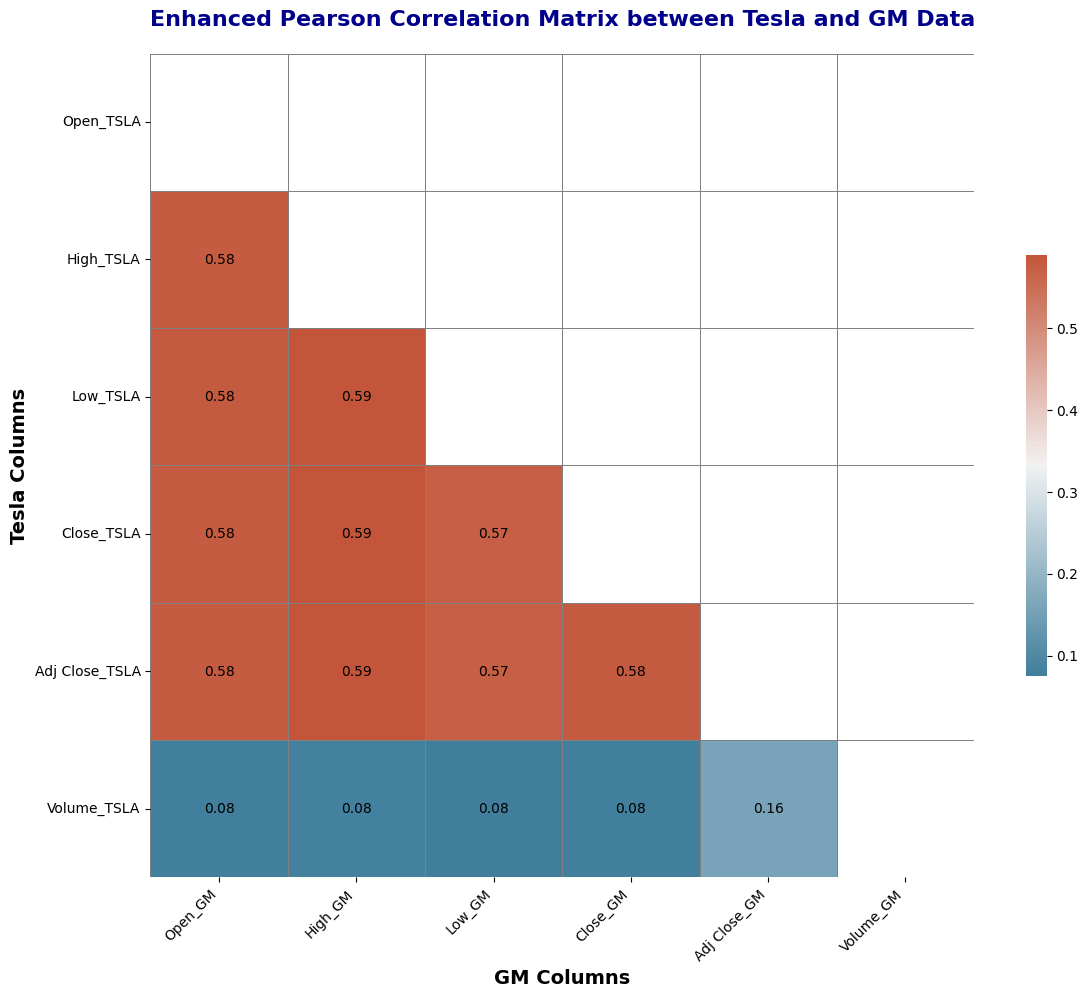

In [ ]:
# Convert correlation matrix to numeric for plotting
corr_matrix_numeric = corr_matrix.astype(float)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_numeric, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_numeric, mask=mask, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.index,
            cbar_kws={"shrink": .5}, square=True, linewidths=.5, linecolor='gray',
            annot_kws={"size": 10, "color": "black"})

# Add titles and labels with enhanced styling
plt.title('Enhanced Pearson Correlation Matrix between Tesla and GM Data', pad=20, fontsize=16, color="darkblue", fontweight='bold')
plt.xlabel('GM Columns', fontsize=14, fontweight='bold')
plt.ylabel('Tesla Columns', fontsize=14, fontweight='bold')

# Improve layout with rotated labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='light')
plt.yticks(rotation=0, fontsize=10, fontweight='light')

# Show plot with a tight layout
plt.tight_layout()
plt.show()

In [ ]:
# What is forecasted to be best performing auto maker of 2024?
from prophet import Prophet
import pandas as pd
import yfinance as yf
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

Top_10_NYSE_Auto = [ 'TSLA','TM','STLA', 'F', 'GM',  'HMC',  'RACE', 'NIO', 'RIVN']
year_input = 2020

df_list = []
for stock in Top_10_NYSE_Auto:
  df = yf.download(stock, period="max")
  df_list.append(df)

In [ ]:
for index, stock in enumerate(df_list):
  stock = stock.fillna(stock.mean())
  nan_in_df_after = stock.isnull().sum()
  print(f"NaN values in the dataset for {stock} after cleaning:\n{nan_in_df_after}")
  df_list[index] = stock

In [ ]:
prophets = []
for index, stock in enumerate(df_list):
  # Preparing data for Prophet
  stock.reset_index(inplace=True)
  stock.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)
  prophet_model = Prophet()
  prophet_model.fit(stock)
  prophets.append(prophet_model)

In [ ]:
def return_eoy():# Forecast Time
  # get current date and find difference in time betweennow and end of year
  today = datetime.date.today()
  end_of_year = datetime.date(today.year, 12, 31)
  delta = end_of_year - today
  return delta.days

In [ ]:
forecasts = []
for index,prophet_model in enumerate(prophets):
 # Create future dataframe and predict
  future = prophet_model.make_future_dataframe(periods=return_eoy())
  forecast = prophet_model.predict(future)
  forecasts.append(forecast)
  fig = prophet_model.plot(forecast)
  plt.title(f'{Top_10_NYSE_Auto[index].upper()} Prophet Forecast')
  plt.show()

In [ ]:
for index, forecast in enumerate(forecasts):
  forecasted_timeframe = forecast.iloc[-return_eoy():, :]
  roi = (forecasted_timeframe.iloc[return_eoy() - 1]["yhat"] - forecasted_timeframe.iloc[0]["yhat"])/forecasted_timeframe.iloc[0]["yhat"]
  print(f"{Top_10_NYSE_Auto[index].upper()} ROI: {round(roi * 100, 2)} percent")